Using device: cpu
[Sigmoid] Epoch 1/5 - Loss: 0.3180, Accuracy: 0.8677
[Sigmoid] Epoch 2/5 - Loss: 0.1075, Accuracy: 0.9476
[Sigmoid] Epoch 3/5 - Loss: 0.1844, Accuracy: 0.9637
[Sigmoid] Epoch 4/5 - Loss: 0.1025, Accuracy: 0.9715
[Sigmoid] Epoch 5/5 - Loss: 0.0919, Accuracy: 0.9772
Training time (Sigmoid): 99.82 seconds

[Tanh] Epoch 1/5 - Loss: 0.3516, Accuracy: 0.9076
[Tanh] Epoch 2/5 - Loss: 0.1711, Accuracy: 0.9549
[Tanh] Epoch 3/5 - Loss: 0.2265, Accuracy: 0.9613
[Tanh] Epoch 4/5 - Loss: 0.3276, Accuracy: 0.9671
[Tanh] Epoch 5/5 - Loss: 0.0769, Accuracy: 0.9695
Training time (Tanh): 99.99 seconds

[ReLU] Epoch 1/5 - Loss: 0.1081, Accuracy: 0.8962
[ReLU] Epoch 2/5 - Loss: 0.0593, Accuracy: 0.9525
[ReLU] Epoch 3/5 - Loss: 0.0645, Accuracy: 0.9644
[ReLU] Epoch 4/5 - Loss: 0.0151, Accuracy: 0.9721
[ReLU] Epoch 5/5 - Loss: 0.0480, Accuracy: 0.9758
Training time (ReLU): 105.94 seconds



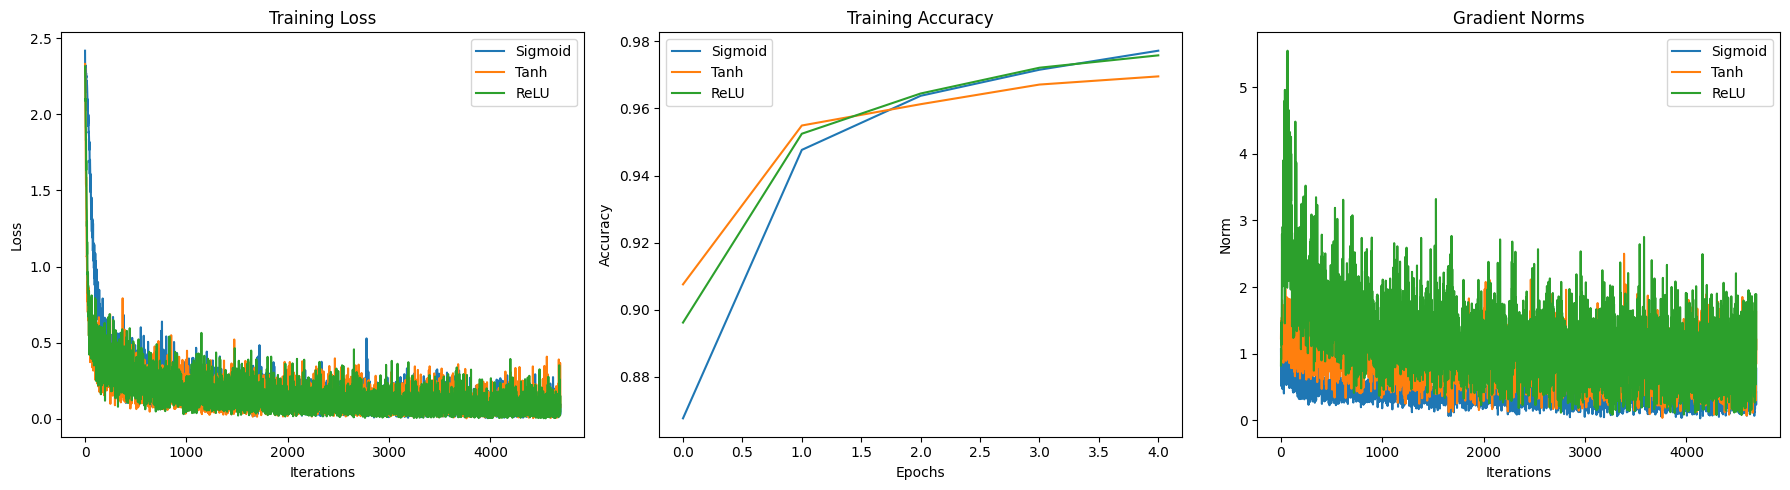

In [ ]:
# -------------------------------------------
# 🔹 Import Libraries
# -------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------------------
# 🔹 Load Dataset (MNIST)
# -------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

# -------------------------------------------
# 🔹 Define MLP Model
# -------------------------------------------
class MLP(nn.Module):
    def __init__(self, activation_fn):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation = activation_fn

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# -------------------------------------------
# 🔹 Training Function
# -------------------------------------------
def train_model(activation_name, activation_fn, epochs=5):
    model = MLP(activation_fn).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    loss_list, acc_list, grad_norms = [], [], []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_correct, total_samples = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Track gradient norm
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            grad_norms.append(total_norm ** 0.5)

            optimizer.step()
            loss_list.append(loss.item())

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        accuracy = total_correct / total_samples
        acc_list.append(accuracy)
        print(f"[{activation_name}] Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

    total_time = time.time() - start_time
    print(f"Training time ({activation_name}): {total_time:.2f} seconds\n")
    return loss_list, acc_list, grad_norms

# -------------------------------------------
# 🔹 Run Experiments for All Activations
# -------------------------------------------
activations = {
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh(),
    "ReLU": nn.ReLU()
}

results = {}
for name, act_fn in activations.items():
    results[name] = train_model(name, act_fn)

# -------------------------------------------
# 🔹 Visualization
# -------------------------------------------
plt.figure(figsize=(18,5))

# Loss curve
plt.subplot(1,3,1)
for name in activations.keys():
    plt.plot(results[name][0], label=name)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1,3,2)
for name in activations.keys():
    plt.plot(results[name][1], label=name)
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Gradient norms
plt.subplot(1,3,3)
for name in activations.keys():
    plt.plot(results[name][2], label=name)
plt.title("Gradient Norms")
plt.xlabel("Iterations")
plt.ylabel("Norm")
plt.legend()

plt.tight_layout()
plt.show()
